In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install numpy
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify
!pip install scipy

  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/b2/jmn732l52_bfvbd4bjpcmydm0000gn/T/pip-req-build-4jkuwyyy
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/b2/jmn732l52_bfvbd4bjpcmydm0000gn/T/pip-req-build-4jkuwyyy
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Using cached scipy-1.13.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (60 kB)
Using cached scipy-1.13.1-cp312-cp312-macosx_12_0_arm64.whl (30.4 MB)


In [231]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image 
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [511]:
from torch.utils.data import Dataset
import cv2
import json


class SAMDataset(Dataset):
    """
    This class is used to create a dataset that serves input images and masks.
    It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
    """
    def __init__(self, images_base_url, masks_base_url, json_url, processor):
        self.images_base_url = images_base_url
        self.masks_base_url = masks_base_url
        self.processor = processor
        self.json_url = json_url
        with open(self.json_url) as file:
            data = json.load(file)
        self.categories = data['categories']
        self.images = data['images']
        self.annotations = data['annotations']

    def __len__(self):
        return len(self.annotations)
    
    @staticmethod
    def get_bounding_box(bbox):
        rand = np.random.randint(20, 120)
        # rand = 0
        # print(rand)
        res = [0 , 0 , 0 , 0]
        res[0] = int(max(0, bbox[0] - rand))
        res[1] = int(max(0, bbox[1] - rand))
        res[2] = int(bbox[2] + 2 * rand)
        res[3] = int(bbox[3] + 2 * rand)
        # print(f"bbox is {bbox}")
        # print(f"res is {res}")
        return res, rand
    
    staticmethod
    def get_largest_bbox(seg_list):
        all_points = []
        for seg in seg_list:
            # Convert the segmentation coordinates to a NumPy array and add to all_points
            segmentation_np = np.array(seg).reshape((-1, 2))
            all_points.append(segmentation_np)
        
        # Concatenate all points into a single array
        all_points = np.vstack(all_points)
        
        # Get the minimum and maximum x and y values
        x_min, y_min = np.min(all_points, axis=0)
        x_max, y_max = np.max(all_points, axis=0)
        
        # Return the bounding box in the format [x_min, y_min, width, height]
        return [x_min, y_min, x_max - x_min, y_max - y_min]
    

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        image_file_name = ''
        for image_info in self.images:
            if image_info['id'] == annotation['image_id']:
                image_file_name = image_info['file_name']
                
        # for category in self.categories:
        #     if category['id'] == annotation['category_id']:
        #         print(category['name'])
                
        
        image = Image.open(os.path.join(self.images_base_url, image_file_name))
        mask = Image.open(os.path.join(self.masks_base_url, image_file_name))

        image = np.array(image)
        if len(image.shape) == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            
        mask = np.zeros((image_info["height"], image_info["width"]), dtype=np.uint8)
        for seg in annotation["segmentation"]:
            segmentation_np = np.array(seg).reshape((-1, 2)).astype(np.int32)
            cv2.fillPoly(mask, [segmentation_np], 255)
        mask = np.array(mask)
        
        # bbox = annotation['bbox']
        bbox = SAMDataset.get_largest_bbox(annotation["segmentation"])
        new_bbox, rand = SAMDataset.get_bounding_box(bbox)
        
        image = image[new_bbox[1]:new_bbox[1] + new_bbox[3], new_bbox[0]:new_bbox[0] + new_bbox[2]]
        mask = mask[new_bbox[1]:new_bbox[1] + new_bbox[3], new_bbox[0]:new_bbox[0] + new_bbox[2]]
        original_width = image.shape[0]
        original_height = image.shape[1]
        
        new_height = 256
        new_width = 256

        # Scaling factors
        scale_x = new_height / original_height
        scale_y = new_width / original_width
        
        bbox[0] = rand * scale_x  # Scale x-coordinates
        bbox[2] *= scale_x  # Scale x-coordinates
        bbox[1] = rand * scale_y  # Scale y-coordinates
        bbox[3] *= scale_y  # Scale y-coordinates
        # get bounding box prompt
        bbox = np.array(bbox)
        prompt = bbox

        
        # prepare image and prompt for the model
        image = cv2.resize(image, (new_width, new_height))
        mask = cv2.resize(mask, (new_width, new_height))
        mask = (mask > 127) * 1

        inputs = self.processor(image, input_boxes=[[[prompt]]], return_tensors="pt")

        # remove batch dimension which the processor adds by default
        # for k,v in inputs.items():
        #     print(k,v.shape)
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

        # add ground truth segmentation
        inputs["ground_truth_mask"] = mask

        return inputs, (image, mask, bbox)

In [512]:
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [513]:
images_base_url = "/Users/amin/Desktop/higharc/Datasets/unlabeled/data_pulte/pulte/floorplans"
masks_base_url = "/Users/amin/Desktop/higharc/Datasets/unlabeled/data_pulte/pulte/panoptic_semseg_floorplans"
json_url = "/Users/amin/Desktop/higharc/Datasets/unlabeled/data_pulte/pulte/floorplans/_annotations.coco.json"

In [514]:
# images_base_url = "/home/ubuntu/dataset/data_pulte/pulte/floorplans"
# masks_base_url = "/home/ubuntu/dataset/data_pulte/pulte/panoptic_semseg_maskdino_augmented_floorplans"
# json_url = "/home/ubuntu/dataset/data_pulte/pulte/floorplans/_annotations.coco.json"

In [515]:
train_dataset = SAMDataset(images_base_url=images_base_url, masks_base_url=masks_base_url, json_url=json_url, processor=processor)

In [516]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, drop_last=False)

47


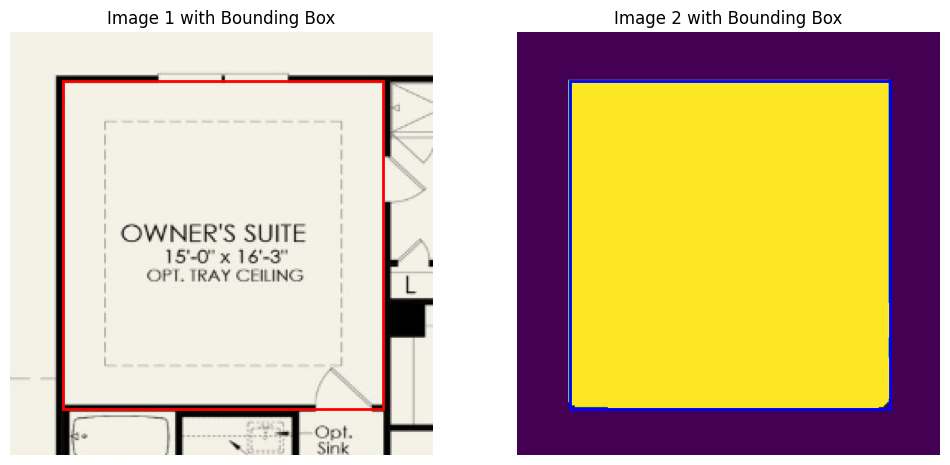

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])
ground_truth_mask torch.Size([1, 256, 256])


In [517]:
batch, info = next(iter(train_dataloader))
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
image, mask, bbox = info

image = image[0]
mask = mask[0]
bbox = bbox[0]

# Plot the first image
axes[0].imshow(image)
rect1 = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
axes[0].add_patch(rect1)
axes[0].set_title("Image 1 with Bounding Box")
axes[0].axis('off')  # Hide the axis

# Plot the second image
axes[1].imshow(mask)
rect2 = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='b', facecolor='none')
axes[1].add_patch(rect2)
axes[1].set_title("Image 2 with Bounding Box")
axes[1].axis('off')  # Hide the axis

plt.show()
for k,v in batch.items():
    print(k,v.shape)

In [518]:
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

In [519]:
from torch.optim import AdamW
import monai
# Initialize the optimizer and the loss function
optimizer = AdamW(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch, _ in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

  0%|          | 0/8688 [00:25<?, ?it/s]


AssertionError: ground truth has different shape (torch.Size([3, 1, 1024, 1024])) from input (torch.Size([3, 1, 256, 256]))